In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/thesis/predictive-coding-thesis/src
! git add FaceForward.ipynb
! git commit -m "modified to have checkpointing"

/content/gdrive/MyDrive/thesis/predictive-coding-thesis/src
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@d6be8f96499b.(none)')


In [ ]:
! git push

fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 12.2 MB/s eta 0:00:00


In [ ]:
%cd /content/gdrive/MyDrive/thesis/predictive-coding-thesis/src

import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision

from torch.utils.data import TensorDataset, DataLoader, random_split

#from tqdm.autonotebook import tqdm, trange

from utils.models import *
from utils.model_tools import *
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

/content/gdrive/MyDrive/thesis/predictive-coding-thesis/src


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

!pwd

Using cuda device
/content/gdrive/MyDrive/thesis/predictive-coding-thesis/src


### Training the Predictive Coder model

In [ ]:
# downsampling to 64x64
%cd /content/gdrive/MyDrive/thesis/predictive-coding-thesis/src

downsample = False

if downsample:
    import cv2
    data_dir = 'data/noisy'
    prefix = 'frames'
    for filename in os.listdir(data_dir):
        if filename.startswith(prefix):
            frames_path = os.path.join(data_dir, filename)
            print(frames_path)
            frames = np.load(frames_path)
            downsampled_images = []

            for frame in frames:
                resized_img = cv2.resize(frame, (64, 64), interpolation=cv2.INTER_AREA)
                downsampled_images.append(resized_img)

            downsampled_stack = np.stack(downsampled_images, axis=0)
            np.save(frames_path, downsampled_stack)


/content/gdrive/MyDrive/thesis/predictive-coding-thesis/src


In [ ]:
# preprocess data by removing consecutive repeat frames
remove_repeats = False

if remove_repeats:
    from utils.data_processing import remove_consecutive_repeats

    data_dir = 'data/face-forward'
    prefix = 'coords'
    for filename in os.listdir(data_dir):
        if filename.startswith(prefix) and not os.path.isdir(filename):
            file_suffix = filename[len(prefix):]
            coords_path = os.path.join(data_dir, filename)
            frames_path = os.path.join(data_dir, 'frames' + file_suffix)
            #print(coords_path)

            #kept_idx = remove_consecutive_repeats(coords_path)

            coords = np.load(coords_path)
            frames = np.load(frames_path)
            if coords.shape[0] != frames.shape[0]:
                print(frames_path)
                print(coords.shape)
                print(frames.shape)
            #np.save(coords_path, coords[kept_idx])
            #np.save(frames_path, frames[kept_idx])
            print(f'removed {len(coords) - len(kept_idx)} from {filename}')

            del coords
            del frames

In [ ]:
torch.manual_seed(321)

# need to consider if you actually want to transform
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = 'data/noisy'

dataset = HeadingDataset(source_directory=data_dir,
                                 transform=transform)

train_ratio = math.floor(len(dataset) * 0.9) - 14000
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{train_ratio} training samples')

batch_size = 32
# does it matter in this instance if you shuffle? I think you can get away with it
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

83143 training samples


In [ ]:
if False:

    frames = np.load('data/face-forward/frames_random_faceforward_2024-01-09-18-25-37.npy')
    coords = np.load('data/face-forward/coords_random_faceforward_2024-01-09-18-25-37.npy')

    def imshow(img):
        #img = img / 2 + 0.5     # unnormalize
        npimg = img#.numpy()
        plt.imshow(npimg)#np.transpose(npimg, (1, 2, 0)))
        plt.show()

    print(frames.shape)
    print(coords.shape)

    for i in range(9010, 9050):
        imshow(frames[i])
        print(coords[i])

In [ ]:
# Take a look at the sequence of images

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

seq, preds = next(iter(train_loader))
frames, headings = seq
print(headings[0])
imshow(torchvision.utils.make_grid(frames[0]))
imshow(preds[0])

In [ ]:
model = PredictiveCoderWithHead()
model.to(device)
print(len(train_loader))

num_epochs = 200 # in the actual example this will be 200
steps_per_epoch = len(train_loader) #?

learning_rate = 0.1
weight_decay = 5 * 10**-6

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch)


2599


In [ ]:

model_file = f'model_files/faceforward_noisy_{train_ratio}_samples-{num_epochs}ep-causal.pt'
model_checkpoint = f'model_files/faceforward_noisy_{train_ratio}_samples-{num_epochs}ep-causal.pth'
train_losses_file = f'logs/faceforward_noisy-ep{num_epochs}-train_{train_ratio}-causal.txt'
test_losses_file = f'logs/faceforward_noisy-ep{num_epochs}-test_{train_ratio}-causal.txt'

train_losses = []
test_losses = []

try:
  # assumes previous checkpoint
  checkpoint = torch.load(model_checkpoint)

  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  start_epoch = checkpoint['epoch']
  test_losses = checkpoint.get('loss_history', [])

  for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_heading(train_loader, model, loss_fn, optimizer, device)
    test_loss = test_heading(test_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    lr_scheduler.step()

    if epoch % 10 == 0:
      state = {
        'epoch': epoch + 1,  # Save next epoch number since current one is completed
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss_history': test_losses,
      }

      # Save the state dictionary; adjust the path as necessary
      torch.save(state, model_checkpoint)


finally:
    torch.save(model.state_dict(), model_file)

    with open(train_losses_file, 'w') as fp:
        for s in train_losses:
            fp.write("%s\n" % s)

    with open(test_losses_file, 'w') as fp:
        for x in test_losses:
            fp.write("%s\n" % x)

    print("Done!")

Epoch 152
-------------------------------
loss: 0.002991  [    0/83143]
loss: 0.003089  [ 2000/83143]
loss: 0.002789  [ 4000/83143]
Test Error: 
 Avg loss: 0.007166 

Epoch 153
-------------------------------
loss: 0.002717  [    0/83143]
loss: 0.002376  [ 2000/83143]
loss: 0.002418  [ 4000/83143]
Test Error: 
 Avg loss: 0.007210 

Epoch 154
-------------------------------
loss: 0.002371  [    0/83143]
loss: 0.002266  [ 2000/83143]
loss: 0.002736  [ 4000/83143]
Test Error: 
 Avg loss: 0.007141 

Epoch 155
-------------------------------
loss: 0.002789  [    0/83143]
loss: 0.002669  [ 2000/83143]
loss: 0.002759  [ 4000/83143]
Test Error: 
 Avg loss: 0.007106 

Epoch 156
-------------------------------
loss: 0.002289  [    0/83143]
loss: 0.003022  [ 2000/83143]
loss: 0.002656  [ 4000/83143]
Test Error: 
 Avg loss: 0.007225 

Epoch 157
-------------------------------
loss: 0.002201  [    0/83143]
loss: 0.002385  [ 2000/83143]
loss: 0.002459  [ 4000/83143]
Test Error: 
 Avg loss: 0.007220 

In [ ]:
# hey girl yoooooo

# keep going please <3
latent_model_file = 'model_files/faceforward_88143_samples-200ep-causal.pt'
latent_model = PredictiveCoderWithHead()
latent_model.to(device)
latent_model.load_state_dict(torch.load(latent_model_file))#, map_location=torch.device(device)))
latent_model.eval()
for param in latent_model.parameters():
    param.requires_grad = False

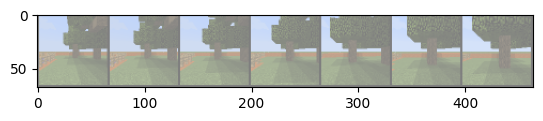

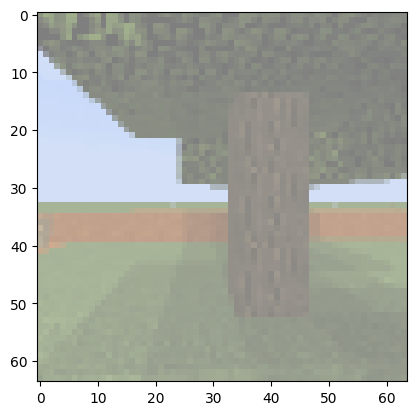

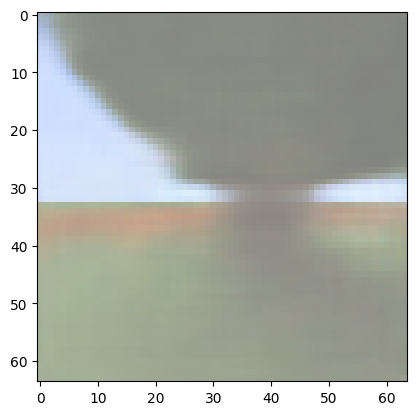

In [ ]:
#print(seq[0].shape, seq[1].shape, corr.shape)

seq, corr = next(iter(test_loader))


imshow(torchvision.utils.make_grid(seq[0][0]))
imshow(corr[0])

with torch.no_grad():
    pred = model(seq[0].to(device), seq[1].to(device)).cpu() # won't this have issues with a batch norm or something if you have one batch

imshow(pred[0])